In [5]:
!pip install sentence_transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/r2/423z207j00sdst2h8y9cdq9h0000gn/T/pip-req-build-l_5j_04g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/r2/423z207j00sdst2h8y9cdq9h0000gn/T/pip-req-build-l_5j_04g
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing

In [17]:
import os
import pickle

import clip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

df_train["label"] = df_train["label"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label"] = df_dev["label"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label"] = df_test["label"].apply(lambda s: 1 if s == "informative" else 0)

In [3]:
def print_metrics(model, X, y):
    """Prints performance metrics"""
    y_pred = model.predict(X) # Predicted labels
    y_pred_proba = model.predict_proba(X) # Predicted probabilities
    
    # Test accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y, y_pred=y_pred)}\n")
    
    # Classification report
    print(metrics.classification_report(y_true=y, y_pred=y_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(
        xlabel="Pred", ylabel="True", 
        xticklabels=[0, 1], yticklabels=[0, 1], 
        title="Confusion Matrix"
    )

    # ROC curve/AUC score
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y, y_score=y_pred_proba[:, 1], pos_label=1
    )
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    ax2.plot(
        fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})"
    )
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

## CLIP

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
train_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_train), batch_size)):
    fps = df_train["image"][i : i + batch_size].apply(lambda s: os.path.join("data", s)).tolist()
    image_batch = torch.cat([preprocess(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)
    text_batch = clip.tokenize(df_train["tweet_text"][i : i + batch_size].apply(lambda s: s[:77])).to(device)

    with torch.no_grad():
        image_batch_features = model.encode_image(image_batch)
        text_batch_features = model.encode_text(text_batch)

    train_embeddings.extend(torch.cat((image_batch_features, text_batch_features), axis=1).tolist())

In [ ]:
with open("train_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(train_embeddings, f)

In [ ]:
dev_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_dev), batch_size)):
    fps = df_dev["image"][i : i + batch_size].apply(lambda s: os.path.join("data", s)).tolist()
    image_batch = torch.cat([preprocess(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)
    text_batch = clip.tokenize(df_dev["tweet_text"][i : i + batch_size].apply(lambda s: s[:77])).to(device)

    with torch.no_grad():
        image_batch_features = model.encode_image(image_batch)
        text_batch_features = model.encode_text(text_batch)

    dev_embeddings.extend(torch.cat((image_batch_features, text_batch_features), axis=1).tolist())

In [ ]:
with open("dev_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(dev_embeddings, f)

In [7]:
with open("train_clip_embeddings.pkl", mode="rb") as f:
    train_embeddings = pickle.load(f)

In [8]:
with open("dev_clip_embeddings.pkl", mode="rb") as f:
    dev_embeddings = pickle.load(f)

Accuracy: 0.8262051734273956

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      5267
           1       0.85      0.88      0.86      8341

    accuracy                           0.83     13608
   macro avg       0.82      0.81      0.81     13608
weighted avg       0.83      0.83      0.83     13608



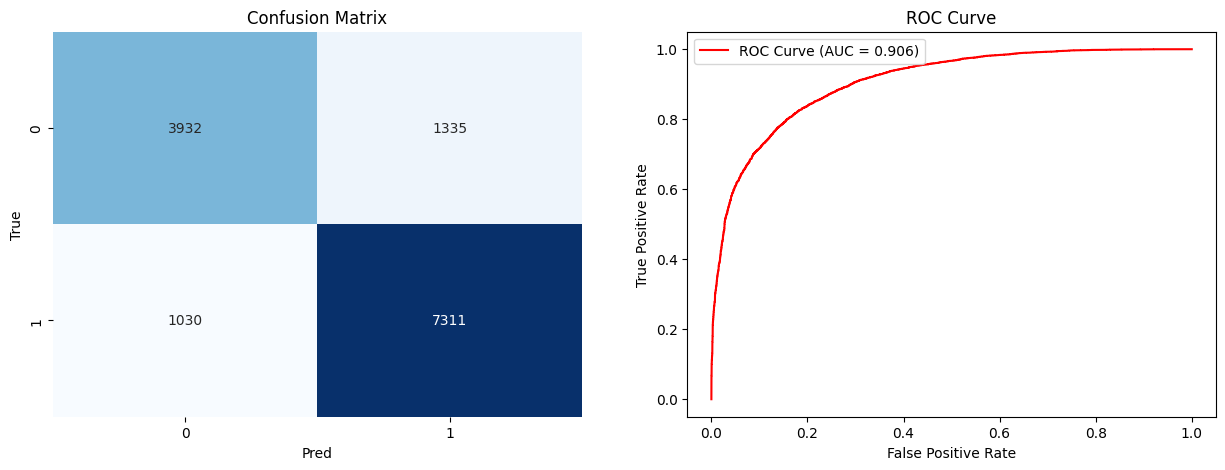

In [9]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(train_embeddings, df_train["label"])
print_metrics(clf, train_embeddings, df_train["label"])

Accuracy: 0.7961555654894948

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       830
           1       0.83      0.84      0.84      1407

    accuracy                           0.80      2237
   macro avg       0.78      0.78      0.78      2237
weighted avg       0.80      0.80      0.80      2237



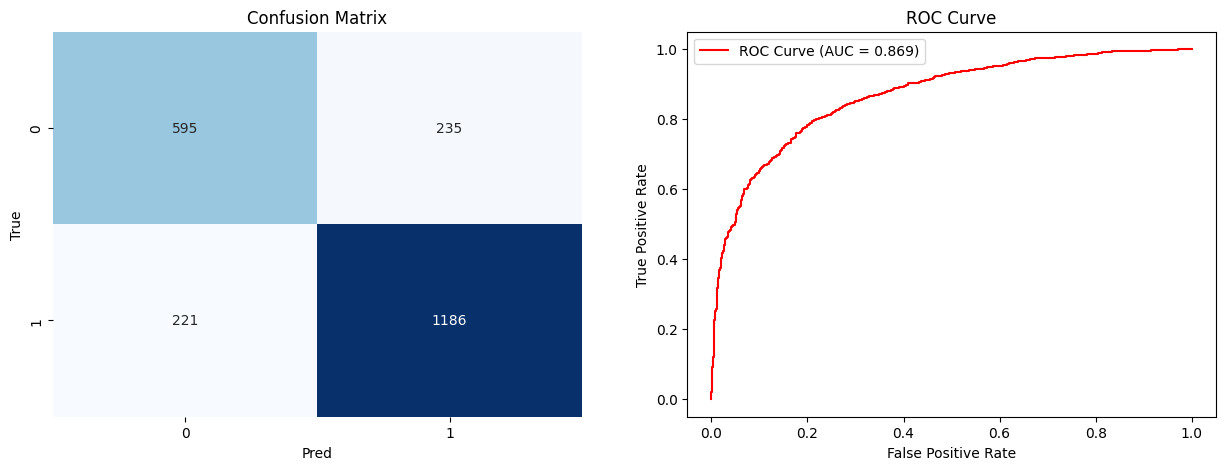

In [10]:
print_metrics(clf, dev_embeddings, df_dev["label"])

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5267
           1       1.00      1.00      1.00      8341

    accuracy                           1.00     13608
   macro avg       1.00      1.00      1.00     13608
weighted avg       1.00      1.00      1.00     13608



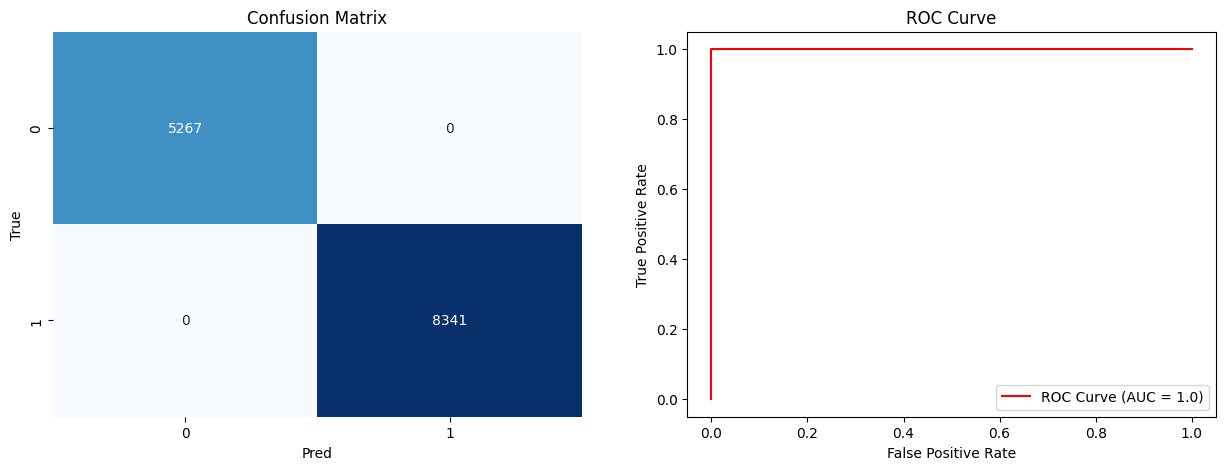

In [12]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_embeddings, df_train["label"])
print_metrics(clf, train_embeddings, df_train["label"])

Accuracy: 0.7930263746088512

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       830
           1       0.82      0.85      0.84      1407

    accuracy                           0.79      2237
   macro avg       0.78      0.77      0.78      2237
weighted avg       0.79      0.79      0.79      2237



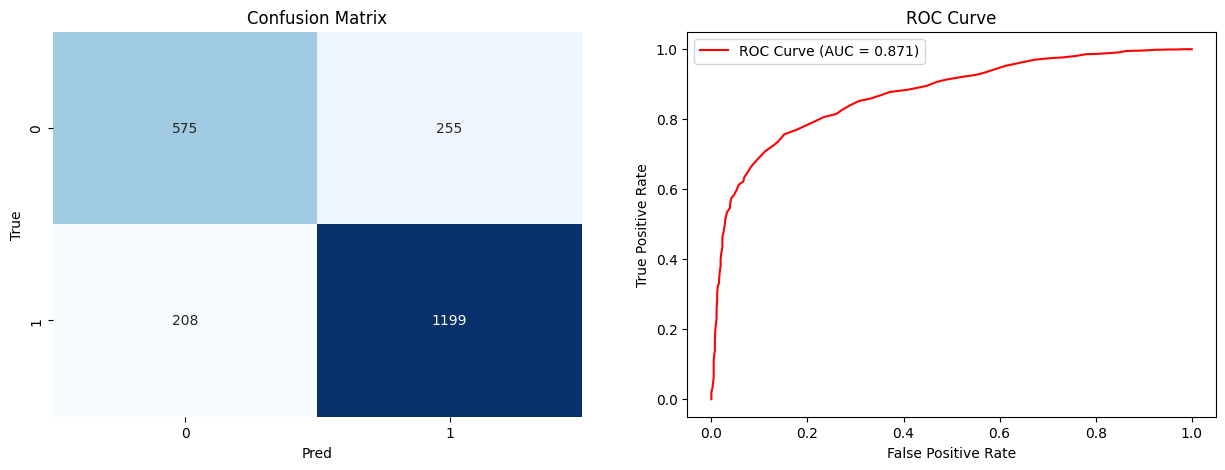

In [13]:
print_metrics(clf, dev_embeddings, df_dev["label"])

## Image Captions

In [15]:
!git clone https://github.com/salesforce/BLIP

Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 277 (delta 137), reused 136 (delta 135), pack-reused 112
Receiving objects: 100% (277/277), 7.03 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [16]:
cd BLIP

/Users/rohan/Projects/multimodal-disaster-tweets-classification/BLIP


/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model = blip_decoder(pretrained=model_url, image_size=384, vit='base')
model.eval()
model = model.to(device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
train_captions = []
batch_size = 64

for i in tqdm(range(0, len(df_train), batch_size)):
    fps = df_train["image"][i : i + batch_size].apply(lambda s: os.path.join("..", "data", s)).tolist()
    image_batch = torch.cat([transform(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)

    with torch.no_grad():
        train_captions.append(model.generate(image_batch, sample=True, top_p=0.9, max_length=20, min_length=5))

image_caption = []
for captions in train_captions:
    image_caption.extend(captions)

df_train["image_caption"] = image_caption

df_train.to_csv("train_with_captions.csv", index=False)

In [ ]:
dev_captions = []
batch_size = 64

for i in tqdm(range(0, len(df_dev), batch_size)):
    fps = df_dev["image"][i : i + batch_size].apply(lambda s: os.path.join("..", "data", s)).tolist()
    image_batch = torch.cat([transform(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)

    with torch.no_grad():
        dev_captions.append(model.generate(image_batch, sample=True, top_p=0.9, max_length=20, min_length=5))

image_caption = []
for captions in dev_captions:
    image_caption.extend(captions)

df_dev["image_caption"] = image_caption

df_dev.to_csv("dev_with_captions.csv", index=False)

In [19]:
cd ..

/Users/rohan/Projects/multimodal-disaster-tweets-classification


/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [20]:
df_train_with_captions = pd.read_csv("train_with_captions.csv")
df_dev_with_captions = pd.read_csv("dev_with_captions.csv")

In [22]:
df_train_with_captions["tweet_text_with_captions"] = df_train_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_dev_with_captions["tweet_text_with_captions"] = df_dev_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)

In [23]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
train_embeddings = sentence_transformer.encode(df_train_with_captions["tweet_text_with_captions"], device=device)

In [ ]:
with open("train_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(train_embeddings, f)``

In [ ]:
dev_embeddings = sentence_transformer.encode(df_dev_with_captions["tweet_text_with_captions"], device=device)

In [ ]:
with open("dev_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(dev_embeddings, f)

In [24]:
with open("train_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    train_embeddings = pickle.load(f)

In [25]:
with open("dev_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    dev_embeddings = pickle.load(f)

Accuracy: 0.7828483245149912

              precision    recall  f1-score   support

           0       0.76      0.64      0.69      5267
           1       0.79      0.88      0.83      8341

    accuracy                           0.78     13608
   macro avg       0.78      0.76      0.76     13608
weighted avg       0.78      0.78      0.78     13608



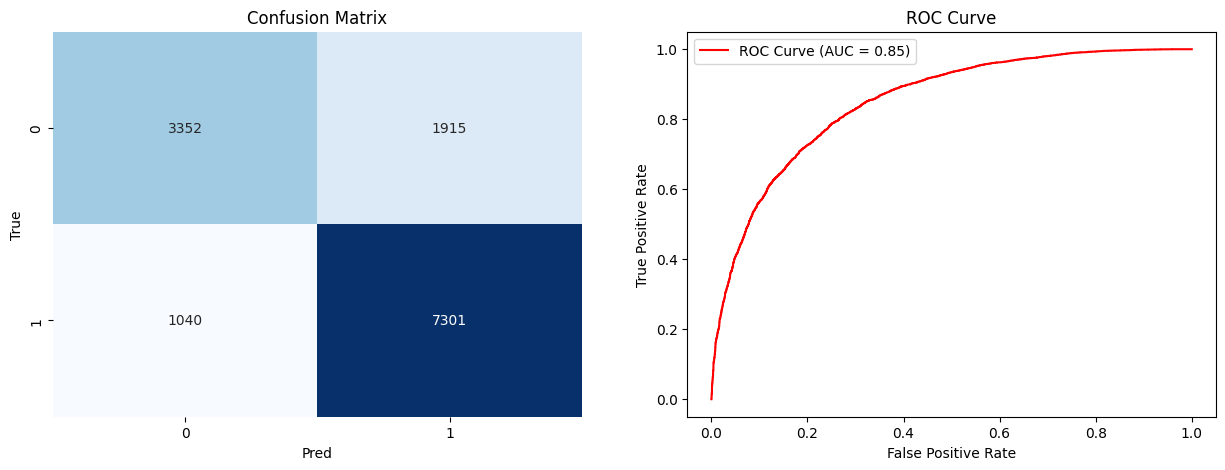

In [26]:
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, df_train_with_captions["label"])
print_metrics(clf, train_embeddings, df_train_with_captions["label"])

Accuracy: 0.7590523021904336

              precision    recall  f1-score   support

           0       0.71      0.59      0.65       830
           1       0.78      0.86      0.82      1407

    accuracy                           0.76      2237
   macro avg       0.75      0.72      0.73      2237
weighted avg       0.75      0.76      0.75      2237



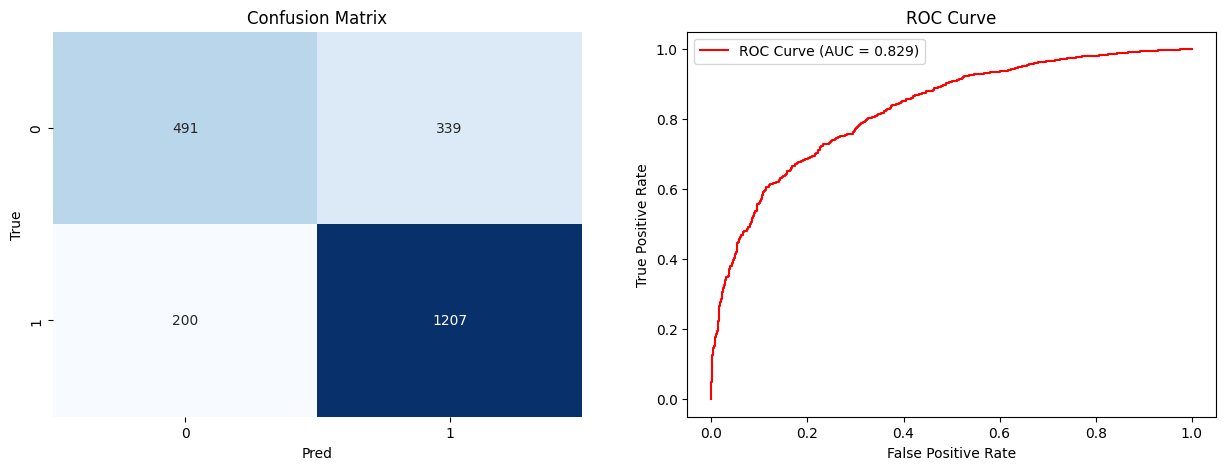

In [27]:
print_metrics(clf, dev_embeddings, df_dev_with_captions["label"])

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5267
           1       1.00      1.00      1.00      8341

    accuracy                           1.00     13608
   macro avg       1.00      1.00      1.00     13608
weighted avg       1.00      1.00      1.00     13608



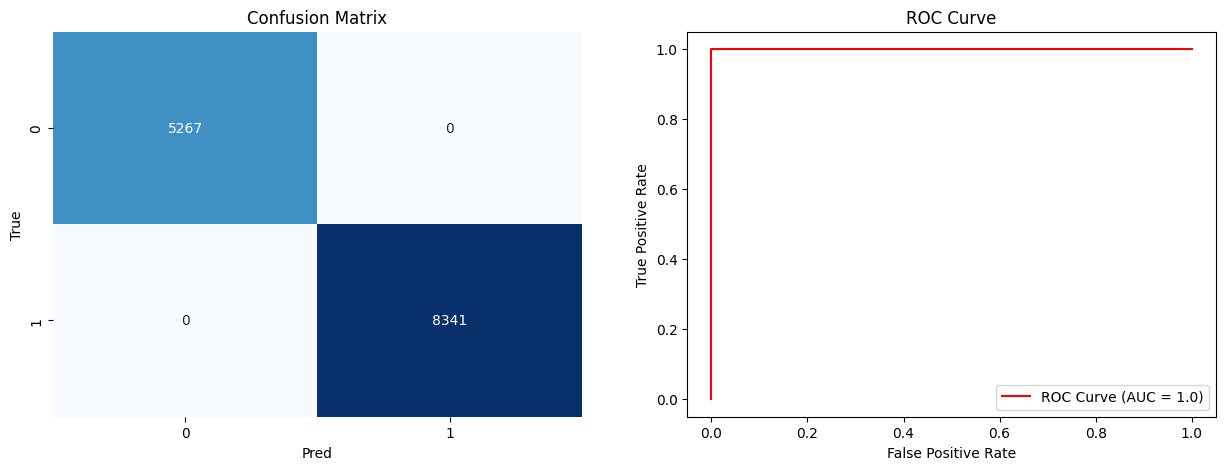

In [28]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_embeddings, df_train_with_captions["label"])
print_metrics(clf, train_embeddings, df_train_with_captions["label"])

Accuracy: 0.7554760840411265

              precision    recall  f1-score   support

           0       0.72      0.55      0.63       830
           1       0.77      0.88      0.82      1407

    accuracy                           0.76      2237
   macro avg       0.75      0.71      0.72      2237
weighted avg       0.75      0.76      0.75      2237



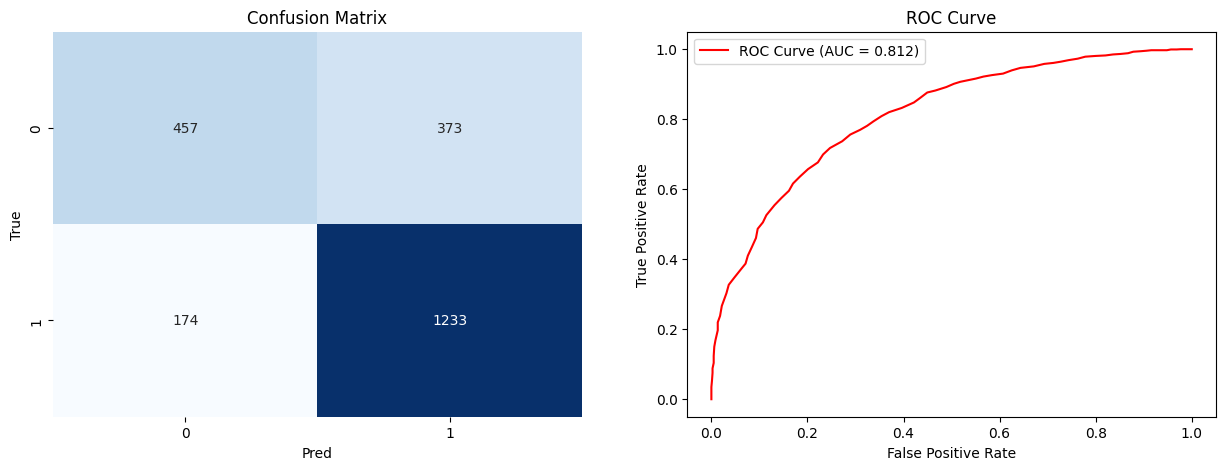

In [29]:
print_metrics(clf, dev_embeddings, df_dev_with_captions["label"])